In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from data_analysis_codes import param
from data_analysis_codes.tools import LinData
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import GetVars_Plot2d as GVar
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

In [2]:
sim = param.pflrw_d3e2_L1821_t1_N128_LCDM()
OGpath = '/home/robynm/simulations/pflrw_d3e2_L1821_t1_N128_LCDM/output-0000/pflrw_L1821/'
path = OGpath+'all_iterations/'+sim.sim_name
Lin = LinData.LinData_Class(sim, '/home/robynm/simulations/'+sim.sim_name+'/')

 read time file


In [3]:
itall = [0,5000,10000,15000,20000,25000,29500,30000,35000,40000,45000]
index = [0,1,   2,    3,    4,    5,    6,    7,    8,    9,    10]

In [4]:
it = itall[6]

In [5]:
FD = FD_file.FD_Class(sim.dx)
RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
get_var = GVar.Get_var(Lin, OGpath)

In [6]:
f = h5py.File('{}_it_{:06d}.hdf5'.format(path, it), 'r')
metric_dic = get_var.get_the_metric(f, it)
gdown = metric_dic['gdown']
gup = metric_dic['gup']
del metric_dic
        
Box_0 = np.zeros(np.shape(gdown[0,0]))
gdown4 = np.array([[-np.ones(np.shape(gdown[0,0])), Box_0, Box_0, Box_0],
                   [Box_0, gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box_0, gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box_0, gdown[2,0], gdown[2,1], gdown[2,2]]])
LCuud3 = np.einsum('ae...,bf...,efc...->abc...', gup, gup, RCW.LeviCivita4(gdown4)[0,1:,1:,1:])
nup = np.array([-np.ones(np.shape(gdown[0,0])), Box_0, Box_0, Box_0])
del gdown4, Box_0
        
Christoffeludd     = RCW.Christoffel_symbol(gdown, gup)
RicciTdown, RicciS = RCW.Ricci_TandS(gup, Christoffeludd)
Kdown = get_var.get_the_curv(f, it)['Kdown']
rho = get_var.get_the_rho(f, it)['rho']

In [7]:
Edict = RCW.Weyl_E(gdown, gup, LCuud3, Christoffeludd, RicciS, RicciTdown, Kdown, Lin.kappa, rho, Lin.Lambda)
Bdict = RCW.Weyl_B(gdown, gup, nup, LCuud3, Christoffeludd, Kdown)
f.close()

E = np.sqrt(Edict['E2'])
divE = Edict['divE_norm']
curlE = Edict['curlE_norm']
B = np.sqrt(Bdict['B2'])
divB = Bdict['divB_norm']
curlB = Bdict['curlB_norm']
del Edict, Bdict

<ipython-input-7-0f913c3f8970>:8: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(Bdict['B2'])


In [8]:
del gdown, gup, LCuud3, nup, Christoffeludd, RicciTdown, RicciS, Kdown, rho

In [33]:
def plot(data):
    plt.pcolormesh(Lin.d3xyz/sim.L, Lin.d3xyz*np.sqrt(2)/sim.L, np.array([data[:, j, j] for j in range(Lin.N)]), cmap=plt.cm.get_cmap('inferno'), shading='gouraud')
    plt.gca().set_aspect("equal")
    plt.colorbar(format='%.1e', extend='both')
def lines():
    lw = 1
    c = 'grey'
    plt.plot(Lin.d3xyz/sim.L, np.sqrt(2)*Lin.d3xyz/sim.L, color=c, linestyle='--', linewidth=lw) # OD face
    plt.plot(Lin.d3xyz[:64]/sim.L, -np.sqrt(2)*0.5-np.sqrt(2)*Lin.d3xyz[:64]/sim.L, color=c, linestyle='--', linewidth=lw) #OD face
    plt.plot(Lin.d3xyz[65:]/sim.L, np.sqrt(2)*(0.5-Lin.d3xyz[65:]/sim.L), color=c, linestyle='--', linewidth=1) #UD face
    
    plt.plot(Lin.d3xyz/sim.L, [-np.sqrt(2)/4]*len(Lin.d3xyz), 'k-', linewidth=lw) # OD arm
    plt.plot([-1/4]*len(Lin.d3xyz), np.sqrt(2)*Lin.d3xyz/sim.L, 'k-.', linewidth=lw) # OD edge
    
    plt.plot(Lin.d3xyz/sim.L, [np.sqrt(2)/4]*len(Lin.d3xyz), 'w-', linewidth=lw) #UD arm
    plt.plot([1/4]*len(Lin.d3xyz), np.sqrt(2)*Lin.d3xyz/sim.L, 'w-.', linewidth=lw) # UD edge

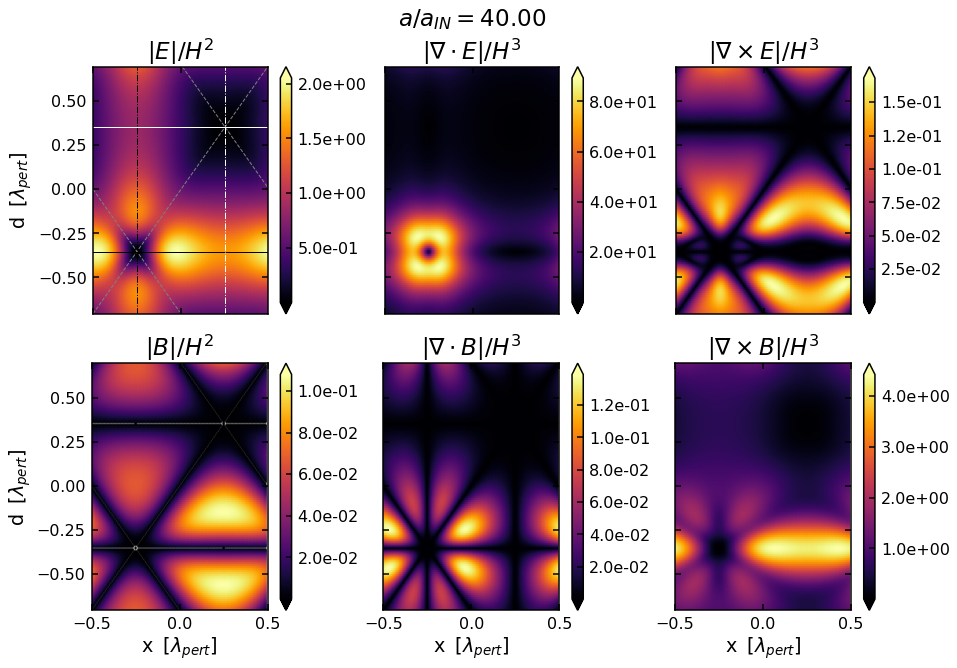

In [34]:
H = Lin.temp_from_temp('H', 'it', it)

fig = plt.figure(figsize=(15,10))

ax = plt.subplot(231)
plot(E/H**2)
plt.title(r'$|E|/H^2$')
plt.ylabel('d'+r'$\;\;[\lambda_{pert}]$')
ax.set_xticklabels(())
lines()

ax = plt.subplot(232)
plot(divE/H**3)
plt.title(r'$a/a_{IN}=$'+'{:.2f}'.format(Lin.temp_from_temp('an', 'it', it))+'\n'+r'$|\nabla \cdot E|/H^3$')
ax.set_xticklabels(())
ax.set_yticklabels(())
#lines()

ax = plt.subplot(233)
plot(curlE/H**3)
plt.title(r'$|\nabla \times E|/H^3$')
ax.set_xticklabels(())
ax.set_yticklabels(())
#lines()

ax = plt.subplot(234)
plot(B/H**2)
ax.set_xticks([-0.5, 0, 0.5])
plt.title(r'$|B|/H^2$')
plt.xlabel('x'+r'$\;\;[\lambda_{pert}]$')
plt.ylabel('d'+r'$\;\;[\lambda_{pert}]$')
#lines()

ax = plt.subplot(235)
plot(divB/H**3)
ax.set_xticks([-0.5, 0, 0.5])
plt.title(r'$|\nabla \cdot B|/H^3$')
plt.xlabel('x'+r'$\;\;[\lambda_{pert}]$')
ax.set_yticklabels(())
#lines()

ax = plt.subplot(236)
plot(curlB/H**3)
ax.set_xticks([-0.5, 0, 0.5])
plt.title(r'$|\nabla \times B|/H^3$');
plt.xlabel('x'+r'$\;\;[\lambda_{pert}]$');
ax.set_yticklabels(());
#lines()
plt.subplots_adjust(wspace = 0.15)
plt.savefig('/home/robynm/simulations/'+sim.sim_name+'/plots/EB_div_curl/'+'{:06d}'.format(it)+'.pdf')